In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
trades = pd.read_csv("historical_data.csv")
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [5]:
print("\nMissing values in sentiment:\n", sentiment.isna().sum())
print("\nMissing values in trades:\n", trades.isna().sum())


Missing values in sentiment:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in trades:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [6]:
print("\nDuplicates in sentiment:", sentiment.duplicated().sum())
print("Duplicates in trades:", trades.duplicated().sum())


Duplicates in sentiment: 0
Duplicates in trades: 0


In [10]:
#Date Alignment

# For sentiment['date'] - assuming format is "2018-02-01" (year-month-day)
sentiment['date'] = pd.to_datetime(sentiment['date'], format='%Y-%m-%d')

# For trades['Timestamp IST'] - using format "18-03-2025 12:50" (day-month-year hour:minute)
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Extracting just the date part
sentiment['day'] = sentiment['date'].dt.date
trades['day'] = trades['Timestamp IST'].dt.date

In [11]:
trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
trades['Size USD'] = pd.to_numeric(trades['Size USD'], errors='coerce')

In [12]:
merged = trades.merge(
    sentiment[['day', 'classification']],
    on='day',
    how='inner'
)

In [13]:
merged['win'] = merged['Closed PnL'] > 0
merged['leverage_proxy'] = merged['Size USD'] / (merged['Start Position'].abs() + 1)

In [17]:
merged.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,day,classification,win,leverage_proxy
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed,False,7872.160000
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed,False,0.129293
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed,False,1.146595
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed,False,0.995191
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed,False,0.054049


In [18]:
#Daily Trader Metrics
daily_metrics = merged.groupby(['Account', 'day', 'classification']).agg(
    daily_pnl
=('Closed PnL', 'sum'),
    trades_count=('Trade ID', 'count'),
    win_rate=('win', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    avg_leverage=('leverage_proxy', 'mean'),
    long_ratio=('Side', lambda x: (x == 'BUY').mean())
).reset_index()


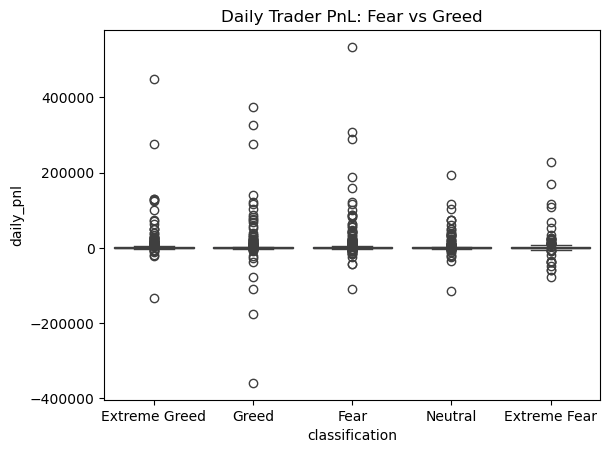

In [19]:
#PnL vs Sentiment
sns.boxplot(
    data=daily_metrics,
    x='classification',
    y='daily_pnl'
)
plt.title("Daily Trader PnL: Fear vs Greed")
plt.show()

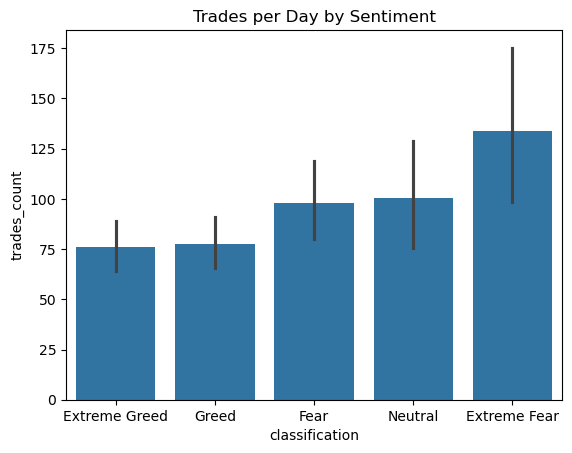

In [20]:
#Trade Frequency by Sentiment
sns.barplot(
    data=daily_metrics,
    x='classification',
    y='trades_count'
)
plt.title("Trades per Day by Sentiment")
plt.show()

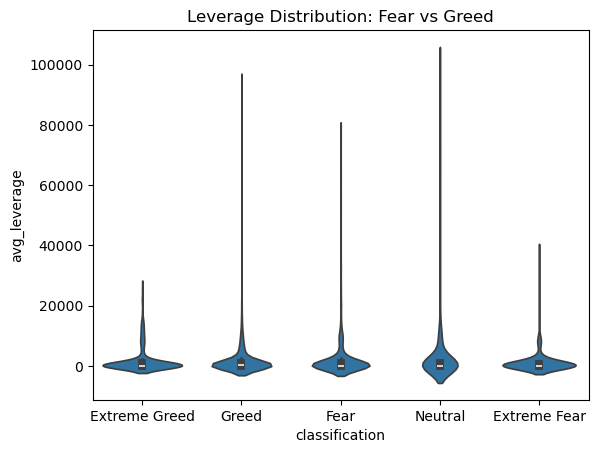

In [21]:
#Leverage Behavior
sns.violinplot(
    data=daily_metrics,
    x='classification',
    y='avg_leverage'
)
plt.title("Leverage Distribution: Fear vs Greed")
plt.show()

In [22]:
#Trader Segmentation
trader_profile = daily_metrics.groupby('Account').agg(
    avg_pnl=('daily_pnl', 'mean'),
    pnl_volatility=('daily_pnl', 'std'),
    avg_leverage=('avg_leverage', 'mean'),
    trade_freq=('trades_count', 'mean'),
    win_rate=('win_rate', 'mean')
).dropna()


In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(trader_profile)

kmeans = KMeans(n_clusters=3, random_state=42)
trader_profile['segment'] = kmeans.fit_predict(X)

trader_profile.head()


C:\Users\akars\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,avg_pnl,pnl_volatility,avg_leverage,trade_freq,win_rate,segment
Account,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,66676.242499,150401.797346,4027.313671,159.083333,0.352333,2
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,920.871548,3603.042291,1191.553922,140.000000,0.397134,1
0x271b280974205ca63b716753467d5a371de622ab,-5869.682610,33420.410014,2405.252317,317.416667,0.379952,0
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,817.684040,2993.284702,139.989993,82.166667,0.452509,1
0x2c229d22b100a7beb69122eed721cee9b24011dd,2444.318913,4867.743469,264.132266,46.942029,0.498708,1
